# HW 02 Malaria Image Detection


In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from torchvision import transforms

# Constants
PATH_TO_TRAIN_LABEL_FILE = "../data/dataset/train_data.csv"
PATH_TO_TRAIN_IMAGES = "../data/dataset/train_images/"
PATH_TO_TEST_IMAGES = "../data/dataset/test_images/"
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

In [19]:
# define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[
                         0.5, 0.5, 0.5])  # Normalize
])

# create dataset class to be used with dataloader one for train and one for test


class MalariaDataset(Dataset):
    def __init__(self, path_to_images, path_to_image_labels_file, transform=None):
        self.path_to_images = path_to_images
        self.path_to_image_labels_file = path_to_image_labels_file
        self.transform = transform

        # image labels from csv file, create df
        self.image_labels = pd.read_csv(self.path_to_image_labels_file)

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, index):
        # index and first column (holds img_names)
        image_path = os.path.join(
            self.path_to_images, self.image_labels.iloc[index, 0])

        # read in the image using torchvision.io.read_image func
        image = read_image(image_path)

        # transform if there are transformations
        if self.transform:
            image = self.transform(image)

        # get label from df (second col)
        label = self.image_labels.iloc[index, 1]

        return image, label


class TestMalariaDataset(Dataset):
    def __init__(self, path_to_images, transform=None):
        self.path_to_images = path_to_images
        self.image_names = os.listdir(path_to_images)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_file_name = self.image_names[index]
        image = read_image(os.path.join(
            self.path_to_images, image_file_name))

        return image, image_file_name


# get full dataset
malaria_dataset = MalariaDataset(
    PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_LABEL_FILE, transform)

# get test dataset
malaria_dataset_test = TestMalariaDataset(PATH_TO_TEST_IMAGES)

# split into training and validation_split
train_size = int((1 - VALIDATION_SPLIT) * len(malaria_dataset))
val_size = len(malaria_dataset) - train_size

train_dataset, val_dataset = random_split(
    malaria_dataset, [train_size, val_size])

# create dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(
    malaria_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

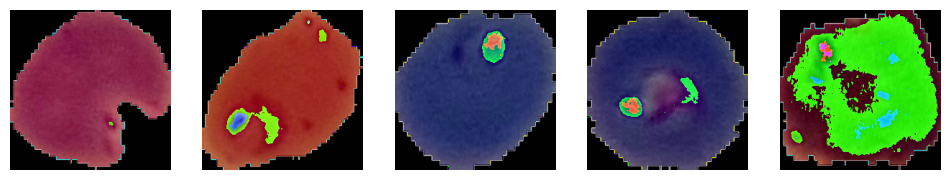

In [21]:
# function to show images
# Convert tensor image to PIL format
to_pil = transforms.ToPILImage()

# Function to show images


def show_images(images, titles=None, num_images=5):
    plt.figure(figsize=(12, 6))

    for i in range(min(num_images, len(images))):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(to_pil(images[i]))  # Convert tensor to image
        plt.axis("off")

        if titles:
            plt.title(titles[i])

    plt.show()


# Get a batch of test images
data_iter = iter(train_dataloader)
images, filenames = next(data_iter)

# Display images
show_images(images)

In [ ]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set model criteria
criterion = torch.nn.CrossEntropyLoss()

# set model optimizer
optimizer = torch.optim.Adam()